In [1]:
# Load Packages
import math
import numpy as np
import pandas as pd
import random
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline

# Import data

In [2]:
# Read Data
test = data.DataReader(['AAPL', 'NKE', 'GOOGL', 'AMZN'], 'yahoo', start='2015/01/01', end='2019/12/31')

test = test['Adj Close']
test.head()

Symbols,AAPL,NKE,GOOGL,AMZN
Date,,,,
2015-01-02,24.861401,44.437469,529.549988,308.519989
2015-01-05,24.161013,43.722023,519.460022,302.190002
2015-01-06,24.163294,43.464821,506.640015,295.290009
2015-01-07,24.502111,44.362659,505.149994,298.420013
2015-01-08,25.443539,45.386726,506.910004,300.459991


#Adding daily % change 

In [3]:

test['% change AAPL'] = test['AAPL'].pct_change()
test['% change NKE'] = test['NKE'].pct_change()
test['% change GOOGL'] = test['GOOGL'].pct_change()
test['% change AMZN'] = test['AMZN'].pct_change()


test.head()

Symbols,AAPL,NKE,GOOGL,AMZN,% change AAPL,% change NKE,% change GOOGL,% change AMZN
Date,,,,,,,,
2015-01-02,24.861401,44.437469,529.549988,308.519989,NaN,NaN,NaN,NaN
2015-01-05,24.161013,43.722023,519.460022,302.190002,-0.028172,-0.016100,-0.019054,-0.020517
2015-01-06,24.163294,43.464821,506.640015,295.290009,0.000094,-0.005883,-0.024679,-0.022833
2015-01-07,24.502111,44.362659,505.149994,298.420013,0.014022,0.020657,-0.002941,0.010600
2015-01-08,25.443539,45.386726,506.910004,300.459991,0.038422,0.023084,0.003484,0.006836


In [ ]:
NAMES = ['AAPL', 'NKE', 'GOOGL', 'AMZN']


In [20]:
NAMES = ['AAPL', 'NKE', 'GOOGL', 'AMZN']

def calculate_semi_variance(name):
    matrix = test['% change ' + name][1:].to_numpy()
    average = np.average(matrix)
    indexs_lower = np.where(matrix < average)[0]
    count_ = len(indexs_lower)
    values = matrix[indexs_lower]
    semi_var = 0
    for x in values:
        semi_var += math.pow((average - x),2)

    return semi_var/count_

def calculate_expected_result(name):
    name = '% change ' + name
    matrix = test[name][1:].to_numpy()
    average_result = np.average(matrix)
    return average_result




semi_variance = {}
expected_results = {}

for x in NAMES:
    semi_variance[x] = calculate_semi_variance(x)
    expected_results[x] = calculate_expected_result(x)






In [21]:
print(semi_variance)
print(expected_results)

{'AAPL': 0.0002520306348946168, 'NKE': 0.00020140290005993218, 'GOOGL': 0.00021386498087066144, 'AMZN': 0.00029497066559904764}
{'AAPL': 0.0009763163236387972, 'NKE': 0.0007578795963829444, 'GOOGL': 0.0008495879461837026, 'AMZN': 0.0015925842997728489}


In [22]:
[0.5, 0.5]
def results_function(p):
    NAMES = ['AAPL', 'NKE', 'GOOGL', 'AMZN']
    res = 0
    for index, name in enumerate(NAMES):
        res += expected_results[name] * p[index]

    return res

def risk_function(p):
    NAMES = ['AAPL', 'NKE', 'GOOGL', 'AMZN']
    risk = 0
    for index, name in enumerate(NAMES):
        risk += semi_variance[name]*p[index]
    return -risk

[0.33, 0.33, 0.33]

p = np.ones(4)/4

print(results_function(p))
print(risk_function(p))

0.0010440920414945733
-0.00024056729535606452


In [23]:
print(semi_variance)
print(expected_results)


{'AAPL': 0.0002520306348946168, 'NKE': 0.00020140290005993218, 'GOOGL': 0.00021386498087066144, 'AMZN': 0.00029497066559904764}
{'AAPL': 0.0009763163236387972, 'NKE': 0.0007578795963829444, 'GOOGL': 0.0008495879461837026, 'AMZN': 0.0015925842997728489}


## Setting up NSGA-II algorithm for our portfolio optimization

# Mutation and crossover 

In [24]:


def insertion_mutation(p):
    def helpr(p,e,indxs):
        HELPER = []
        
        for x in indxs:
            if x>= p and x<e:
                HELPER.append(x)
            
            
        return HELPER
    
    element= np.random.randint(0, len(p)-1)
    place = np.random.randint(0, len(p)-1)
    while(element == place):
        element= np.random.randint(0, len(p)-1)
        place = np.random.randint(0, len(p)-1)
   
    
    if place>element:
        a=place
        b=element
        element=a
        place=b
    
    
  
    helper = p.copy()
    values = helper[helper != p[element]]
    
    INDEXS = []

    for x in values:
        INDEXS.append(list(helper).index(x))
        
   
    END_INDXS = helpr(place,element,INDEXS)
    p[place] = helper[element]
    
    VALUES = helper[END_INDXS]
    
    END_INDXS = np.array(END_INDXS)
    END_INDXS = END_INDXS + 1
    END_INDXS = list(END_INDXS)
 
    p[END_INDXS] = VALUES

    return p


# Helper functions for algorithm


In [25]:
def non_dominating_curve_plotter(objective1_values, objective2_values):
    plt.figure(figsize=(15,8))
    objective1 = [i*-1 for i in objective1_values]
    objective2 = [j*-1 for j in objective2_values]
    plt.xlabel('Objective Function 1', fontsize=15)
    plt.ylabel('Objective Function 2', fontsize=15)
    plt.scatter(objective1, objective2, c='red', s=25)

def index_locator(a,list):
    for i in range(0,len(list)):
        if list[i] == a:
            return i
    return -1

def sort_by_values(list1, values):
    sorted_list = []
    while(len(sorted_list)!=len(list1)):
        if index_locator(min(values),values) in list1:
            sorted_list.append(index_locator(min(values),values))
        values[index_locator(min(values),values)] = math.inf
    return sorted_list


def crowding_distance(values1, values2, front):
    distance = [0 for i in range(0,len(front))]
    sorted1 = sort_by_values(front, values1[:])
    sorted2 = sort_by_values(front, values2[:])
    distance[0] = 4444444444444444
    distance[len(front) - 1] = 4444444444444444
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted2[k+1]] - values2[sorted2[k-1]])/(max(values2)-min(values2))
    return distance

def crossover(a,b):
    r=random.random()
    if r>0.5:
        return mutation((a+b)/2)
    else:
        return mutation(a)
    
    
def mutation(solution):
    i = np.random.randint(0,4)
    j = np.random.randint(0,4)
    while (i==j):
        j= np.random.randint(0,4)
    percent = solution[i]*0.4
    solution[j] +=percent
    solution[i] -=percent

    return solution

In [26]:
def non_dominated_sorting_algorithm(values1, values2):
    S=[[] for i in range(0,len(values1))]
    front = [[]]
    n=[0 for i in range(0,len(values1))]
    rank = [0 for i in range(0, len(values1))]

    for p in range(0,len(values1)):
        S[p]=[]
        n[p]=0
        for q in range(0, len(values1)):
            if (values1[p] > values1[q] and values2[p] > values2[q]) or (values1[p] >= values1[q] and values2[p] > values2[q]) or (values1[p] > values1[q] and values2[p] >= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] > values1[p] and values2[q] > values2[p]) or (values1[q] >= values1[p] and values2[q] > values2[p]) or (values1[q] > values1[p] and values2[q] >= values2[p]):
                n[p] = n[p] + 1
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)
    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)

    del front[len(front)-1]
    return front

# NSGA-II

In [27]:
def nsga2(population,max_gen, f1, f2, n):
    objective1 = f1
    objective2 = f2
    gen_no=0
    solution = []
    for i in range(population):
        p = np.random.randint(0,100000,n)
        p = p/np.sum(p)
        solution.append(p)

    while(gen_no<max_gen):
        objective1_values = [objective1(solution[i])for i in range(0,population)]
        objective2_values = [objective2(solution[i])for i in range(0,population)]
        non_dominated_sorted_solution = non_dominated_sorting_algorithm(objective1_values[:],objective2_values[:])
        print('Best Front for Generation:',gen_no)
        for values in non_dominated_sorted_solution[0]:
            print(solution[values],end=" ")
            print(objective1(solution[values]) + objective2(solution[values]))
        print("\n")
        crowding_distance_values=[]
        for i in range(0,len(non_dominated_sorted_solution)):
            crowding_distance_values.append(crowding_distance(objective1_values[:],objective2_values[:],non_dominated_sorted_solution[i][:]))
        solution2 = solution[:]
        
        while(len(solution2)!=2*population):
            a1 = random.randint(0,population-1)
            b1 = random.randint(0,population-1)
            solution2.append(crossover(solution[a1],solution[b1]))
        objective1_values2 = [objective1(solution2[i])for i in range(0,2*population)]
        objective2_values2 = [objective2(solution2[i])for i in range(0,2*population)]
        non_dominated_sorted_solution2 = non_dominated_sorting_algorithm(objective1_values2[:],objective2_values2[:])
        crowding_distance_values2=[]
        for i in range(0,len(non_dominated_sorted_solution2)):
            crowding_distance_values2.append(crowding_distance(objective1_values2[:],objective2_values2[:],non_dominated_sorted_solution2[i][:]))
        new_solution= []
        for i in range(0,len(non_dominated_sorted_solution2)):
            non_dominated_sorted_solution2_1 = [index_locator(non_dominated_sorted_solution2[i][j],non_dominated_sorted_solution2[i] ) for j in range(0,len(non_dominated_sorted_solution2[i]))]
            front22 = sort_by_values(non_dominated_sorted_solution2_1[:], crowding_distance_values2[i][:])
            front = [non_dominated_sorted_solution2[i][front22[j]] for j in range(0,len(non_dominated_sorted_solution2[i]))]
            front.reverse()
            for value in front:
                new_solution.append(value)
                if(len(new_solution)==population):
                    break
            if (len(new_solution) == population):
                break
        solution = [solution2[i] for i in new_solution]
        gen_no = gen_no + 1
    return [objective1_values, objective2_values, solution]

In [29]:
objective1_values, objective2_values, solution = nsga2(100,50,results_function, risk_function,4)

Best Front for Generation: 0
[0.0032745  0.0672783  0.43592436 0.49352283] 0.0009573395685321489
[0.04179762 0.09238736 0.64256359 0.22325143] 0.0007798713635567217
[0.01455711 0.15784513 0.21904782 0.60854994] 0.0010272970746642823
[0.06034155 0.50314642 0.01991433 0.4165977 ] 0.0008769366313958347
[0.05345478 0.21775944 0.45944645 0.26933932] 0.0008014736275620193
[0.00603211 0.45937641 0.03820506 0.49638643] 0.0009284068630873283
[0.03249455 0.02098717 0.43569937 0.51081891] 0.0009750438853522253
[0.09953593 0.44068472 0.27027792 0.18950142] 0.0007350447424786809
[0.12132577 0.29871519 0.17246407 0.40749498] 0.0008925129641083637
[0.0786084  0.54681743 0.27761358 0.09696058] 0.0006635288034464693
[0.01426126 0.51927801 0.10854485 0.35791589] 0.0008327363253788633
[0.02814211 0.45042108 0.15505414 0.36638268] 0.0008450263917838285
[0.02158081 0.49872694 0.27098876 0.20870348] 0.0007362508597054587
[0.06577171 0.16915361 0.58898027 0.17609441] 0.0007446983438597417
[0.00873202 0.37317

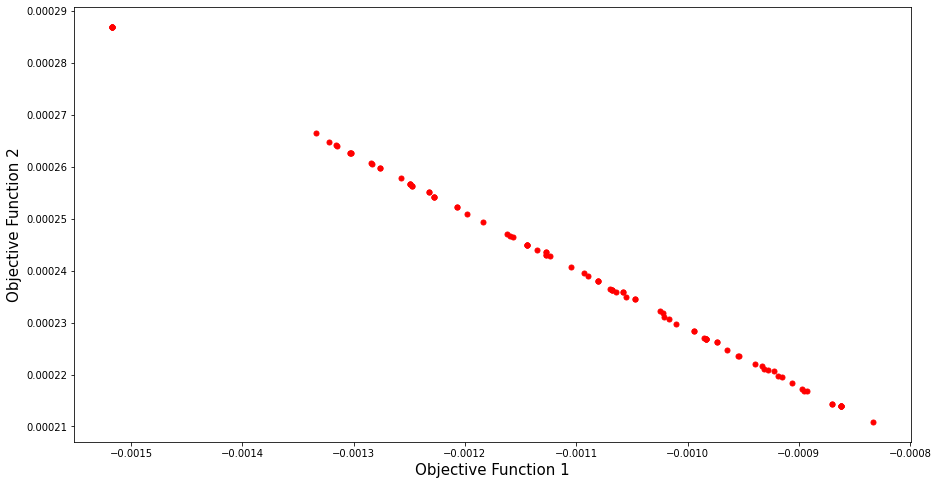

In [30]:
non_dominating_curve_plotter(objective1_values, objective2_values)

In [ ]:
print(solution[0])
# 0.00628184289 # 0.993582254